In [15]:
import torch
import time
import warnings
import random
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve

from lion_pytorch import Lion 

from collections import defaultdict

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, add_self_loops, coalesce
from torch_geometric.nn import SAGEConv

from window_slider import Slider

In [16]:
warnings.filterwarnings('ignore')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [17]:
# Load the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path, nrows = 1600000)
    return df

def data_desc(data):
    print()
    print("DATA DESCRIPTION")
    print("Data size (Records, Features):", data.shape)
    
    feature_desc = pd.DataFrame(
                                (zip(data.columns, 
                                    [data[col].dtype for col in data.columns], 
                                    data.nunique(), 
                                    data.isna().sum()/data.shape[0] * 100)), 
                    columns=["Name", "Type", "Unique levels", "Missing Ratio %"])
    print("Features description:\n", feature_desc)
    
    print("Duplicate rows:", data.duplicated().sum())


def split_and_prepare_data(df, train_ratio=0.6, val_ratio=0.2):
    # Drop duplicates to avoid data leakage
    df = df.drop_duplicates()

    # Shuffle before splitting
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

 # Ensure at least one of each attack type in the dataset
    unique_attacks = df.groupby('Attack').apply(lambda x: x.sample(1, random_state=SEED)).reset_index(drop=True)
    remaining_df = df.drop(index=unique_attacks.index)

    # Shuffle remaining data
    remaining_df = remaining_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Combine guaranteed attack coverage with remaining
    combined_df = pd.concat([unique_attacks, remaining_df], ignore_index=True)

    # Now stratified split on combined_df
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=SEED)
    for train_idx, test_val_idx in strat_split.split(combined_df, combined_df['Attack']):
        train = combined_df.iloc[train_idx]
        test_val = combined_df.iloc[test_val_idx]

    # Split validation and test
    val_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - train_ratio), random_state=SEED)
    for val_idx, test_idx in val_split.split(test_val, test_val['Attack']):
        validation = test_val.iloc[val_idx]
        test = test_val.iloc[test_idx]

    # Sanity check: make sure every attack appears in the train set
    missing_attacks = set(df['Attack'].unique()) - set(train['Attack'].unique())
    if missing_attacks:
        print(f"Warning: The following attack types are missing from the training set: {missing_attacks}")

    # Print dataset sizes and attack distribution
    print(f"Training set: {train.shape[0]} samples")
    print(train['Attack'].value_counts(), "\n")

    print(f"Validation set: {validation.shape[0]} samples")
    print(validation['Attack'].value_counts(), "\n")

    print(f"Test set: {test.shape[0]} samples")
    print(test['Attack'].value_counts(), "\n")

    # Separate features and labels
    train_target = train["Label"]
    validation_target = validation["Label"]
    test_target = test["Label"]

    # Drop unnecessary columns
    drop_cols = ["Label", "Attack", "Dataset"]
    train_features = train.drop(columns=drop_cols)
    validation_features = validation.drop(columns=drop_cols)
    test_features = test.drop(columns=drop_cols)

    return train_features, train_target, validation_features, validation_target, test_features, test_target


def data_preprocessing(features, scaler=None):
    # Replace inf/-inf with NaN and drop rows
    features = features.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Extract and encode nodes
    snode = features['IPV4_SRC_ADDR'].astype(str) + '-' + features['L4_SRC_PORT'].astype(str)
    dnode = features['IPV4_DST_ADDR'].astype(str) + '-' + features['L4_DST_PORT'].astype(str)
    
    # Drop original columns
    features = features.drop(columns=['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT'])
    
    # Fit the scaler only on the training set
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0,1))
        features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    else:
        features = pd.DataFrame(scaler.transform(features), columns=features.columns)
    
    return features, snode, dnode, scaler

     IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0  192.168.100.148        65389  192.168.100.7           80         6   
1  192.168.100.148        11154  192.168.100.5           80         6   
2     192.168.1.31        42062   192.168.1.79         1041         6   
3     192.168.1.34        46849   192.168.1.79         9110         6   

   L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  ...  TCP_WIN_MAX_OUT  \
0       7.0       420        3          0         0  ...                0   
1       7.0       280        2         40         1  ...                0   
2       0.0        44        1         40         1  ...                0   
3       0.0        44        1         40         1  ...                0   

   ICMP_TYPE  ICMP_IPV4_TYPE  DNS_QUERY_ID  DNS_QUERY_TYPE  DNS_TTL_ANSWER  \
0      35840             140             0               0               0   
1          0               0             0               0               0   
2          0  

<Axes: >

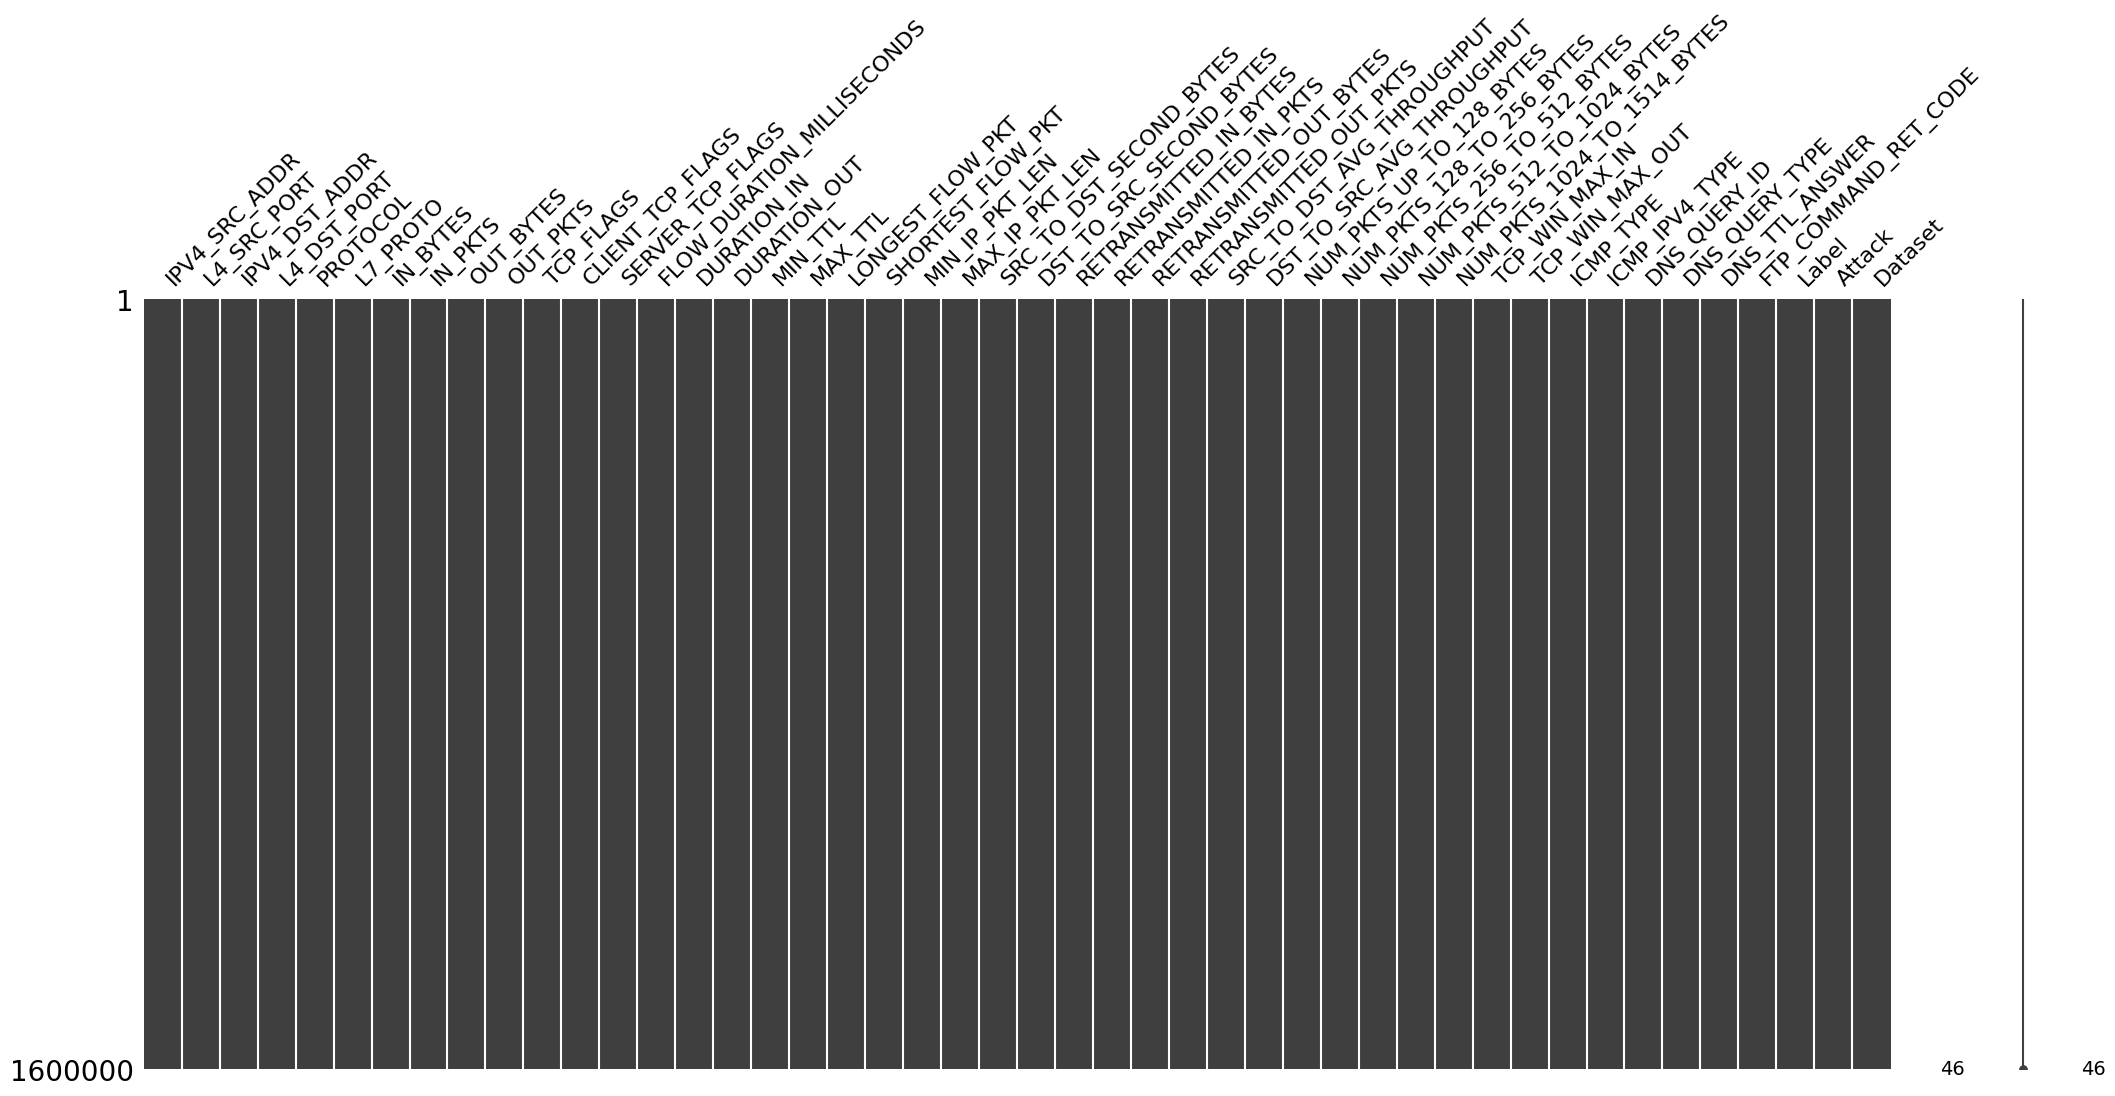

In [18]:
# Prepare the device (Check for cuda availability)
path = 'D:/TA2/Dataset'
# Load the dataset
df = load_dataset(path + "/NF-UQ-NIDS-v2.csv")

# # Check the integrity of the dataset
print(df.head(4))
data_desc(df)
msno.matrix(df)

In [19]:
# Split the dataset
train_features, train_target, validation_features, validation_target, test_features, test_target = split_and_prepare_data(df)

# Preprocess the dataset
train_features, train_snode, train_dnode, scaler = data_preprocessing(train_features)
validation_features, validation_snode, validation_dnode, _ = data_preprocessing(validation_features, scaler)
test_features, test_snode, test_dnode, _,  = data_preprocessing(test_features, scaler)

# Check the processed data
print("Processed Features:")
print(train_features.head())
print("\nSource Nodes:")
print(train_snode[:10])
print("\nDestination Nodes:")
print(train_dnode[:10])
print("length")
print(train_features.shape)

Training set: 959976 samples
Attack
Benign            317605
DDoS              274805
DoS               226061
scanning           48149
Reconnaissance     33011
xss                31011
password           14429
injection           8639
Bot                 1829
Brute Force         1611
Infilteration       1483
Exploits             391
Fuzzers              288
Backdoor             237
Generic              221
mitm                  86
ransomware            40
Analysis              34
Theft                 26
Shellcode             17
Worms                  3
Name: count, dtype: int64 

Validation set: 319992 samples
Attack
Benign            105869
DDoS               91602
DoS                75353
scanning           16050
Reconnaissance     11004
xss                10337
password            4809
injection           2880
Bot                  610
Brute Force          537
Infilteration        494
Exploits             130
Fuzzers               96
Backdoor              79
Generic               7

In [20]:
def graph(features, snode, dnode, target, kernel_size=50, train_ratio=0.7, is_train = False):
    
    num_flows = len(features)
    
    # === Structural Edges (Shared Endpoints) ===
    endpoint_groups = defaultdict(list)
    for idx, (s, d) in enumerate(zip(snode, dnode)):
        endpoint_groups[s].append(idx)  # Group by source
        endpoint_groups[d].append(idx)  # Group by destination

    # Generate edges for flows sharing endpoints
    struct_edges = []
    for group in endpoint_groups.values():
        if len(group) > 1:
            pairs = torch.combinations(torch.tensor(group), r=2)
            struct_edges.append(pairs)
    
    struct_edge_index = torch.cat(struct_edges, dim=0).t() if struct_edges else torch.empty((2, 0), dtype=torch.long)
    struct_edge_index = to_undirected(struct_edge_index)
    struct_edge_index = coalesce(struct_edge_index, num_nodes=num_flows)  # Remove duplicates
    struct_edge_index, _ = add_self_loops(struct_edge_index, num_nodes=num_flows)  # Add self-loops

    # === Temporal Edges (Past-Only Connections) ===
    nodes = torch.arange(num_flows)
    offsets = -torch.arange(1, kernel_size + 1)  # Only look backward
    
    # Vectorized implementation for efficiency
    src = nodes.unsqueeze(1) + torch.zeros_like(offsets)
    dst = nodes.unsqueeze(1) + offsets
    mask = (dst >= 0)  # Filter invalid indices
    
    temp_edge_index = torch.stack([
        src[mask].flatten(),
        dst[mask].flatten()
    ])

    if is_train:
        # Mask labels for semi-supervised training (e.g., 50% labeled)
        num_labels = int(num_flows * train_ratio)
        label_mask = torch.zeros(num_flows, dtype=torch.bool)
        label_indices = torch.randperm(num_flows)[:num_labels]  # Random selection
        label_mask[label_indices] = True
    else:
        # Validation/test: Use all labels for evaluation
        label_mask = torch.ones(num_flows, dtype=torch.bool)

    return Data(
        x=torch.tensor(features.values, dtype=torch.float),
        y=torch.tensor(target.values.ravel(), dtype=torch.long),  # Ensure y is 1D
        struct_edge_index=struct_edge_index,
        temp_edge_index=temp_edge_index,
        label_mask=label_mask
    )


In [21]:
def snapshots(features, snode, dnode, target, kernel_size, buffer_size, overlap_count, is_train = False):

    snapshots = []
    idx = np.arange(features.shape[0])
    slider = Slider(buffer_size, overlap_count)
    slider.fit(idx)     

    while True:
        window_data = slider.slide()

        idx_start = window_data[0]
        idx_end = window_data[-1]+1
        snapshot = graph(features=features[idx_start:idx_end], snode=snode[idx_start:idx_end], dnode=dnode[idx_start:idx_end], 
                       target=target[idx_start:idx_end], kernel_size=kernel_size, is_train = is_train)
        snapshots.append(snapshot)

        if slider.reached_end_of_list(): break

    return snapshots

In [22]:
%%time

# Training Snapshot
train_snapshots = snapshots(features=train_features, snode=train_snode, dnode=train_dnode, target=train_target, 
             kernel_size=50, buffer_size=512, overlap_count=256, is_train = True)

print("Training Snapshot")

torch.save(train_snapshots, path+'/train_snapshots.pt')

Training Snapshot
CPU times: total: 1min 44s
Wall time: 20.5 s


In [23]:
%%time

# Validation Snapshot
validation_snapshots = snapshots(features=validation_features, snode=validation_snode, dnode=validation_dnode, target=validation_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("validation Snapshots")

torch.save(validation_snapshots, path+'/validation_snapshots.pt')

validation Snapshots
CPU times: total: 35.6 s
Wall time: 6.69 s


In [24]:
%%time

# Test Snapshot
test_snapshots = snapshots(features=test_features, snode=test_snode, dnode=test_dnode, target=test_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("test Snapshots")

torch.save(test_snapshots, path+'/test_snapshots.pt')

test Snapshots
CPU times: total: 37.6 s
Wall time: 6.97 s


In [25]:
train_snapshots = torch.load(path+'/train_snapshots.pt')
validation_snapshots = torch.load(path+'/validation_snapshots.pt')
test_snapshots = torch.load(path+'/test_snapshots.pt')

# Uses GPU
train_snapshots = [train_snapshot.to(device) for train_snapshot in train_snapshots]
validation_snapshots = [validation_snapshot.to(device) for validation_snapshot in validation_snapshots]
test_snapshots = [test_snapshot.to(device) for test_snapshot in test_snapshots]

# Shuffle
random.shuffle(train_snapshots)
random.shuffle(validation_snapshots)
random.shuffle(test_snapshots)

print("training snapshot : ", len(train_snapshots))
print("validation snapshot : ", len(validation_snapshots))
print("test snapshot : ", len(test_snapshots))

training snapshot :  3749
validation snapshot :  1249
test snapshot :  1249


In [26]:
# --------------------------
# 1. GNN Autoencoder
# --------------------------
class GNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()

        # Structural encoder
        self.struct_enc1 = SAGEConv(input_dim, hidden_dim)
        self.struct_enc2 = SAGEConv(hidden_dim, latent_dim)

        # Temporal encoder
        self.temp_enc1 = SAGEConv(input_dim, hidden_dim)
        self.temp_enc2 = SAGEConv(hidden_dim, latent_dim)

        # fusion weights
        self.alpha = 0.4

        # Decoder
        self.dec1 = SAGEConv(latent_dim, hidden_dim)
        self.dec2 = SAGEConv(hidden_dim, input_dim)

    def encode(self, x, struct_edge_index, temp_edge_index):
        s = self.activation(self.struct_enc1(x, struct_edge_index))
        s = self.struct_enc2(s, struct_edge_index)

        t = self.activation(self.temp_enc1(x, temp_edge_index))
        t = self.temp_enc2(t, temp_edge_index)

        # 🔹 Adaptive fusion
        z = self.alpha * s + (1 - self.alpha) * t
        return z

    def decode(self, z, edge_index):
        h = self.activation(self.dec1(z, edge_index))
        return torch.sigmoid(self.dec2(h, edge_index))

    def forward(self, x, struct_edge_index, temp_edge_index):
        z = self.encode(x, struct_edge_index, temp_edge_index)
        x_recon_s = self.decode(z, struct_edge_index)
        x_recon_t = self.decode(z, temp_edge_index)
        x_recon = (self.alpha * x_recon_s) + ((1 - self.alpha) * x_recon_t)
        return z, x_recon


# --------------------------
# 2. StructTemp-GNN
# --------------------------
class StructTempGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Structural dependencies
        self.struct_conv1 = SAGEConv(input_dim, hidden_dim)
        self.struct_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.struct_conv3 = SAGEConv(hidden_dim, hidden_dim)

        # Temporal dependencies
        self.temp_conv1 = SAGEConv(input_dim, hidden_dim)
        self.temp_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.temp_conv3 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, x, struct_edge_index, temp_edge_index):
        # Structural embeddings
        s = F.relu(self.struct_conv1(x, struct_edge_index))
        s = F.relu(self.struct_conv2(s, struct_edge_index))
        s = F.relu(self.struct_conv3(s, struct_edge_index))

        # Temporal embeddings
        t = F.relu(self.temp_conv1(x, temp_edge_index))
        t = F.relu(self.temp_conv2(t, temp_edge_index))
        t = F.relu(self.temp_conv3(t, temp_edge_index))

        return torch.cat([s, t], dim=1)  # 🔹 Output shape: (batch, hidden_dim * 2)


# --------------------------
# 3. Semi-Supervised Model
# --------------------------
class SemiSupervisedStructTempAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Shared components
        self.struct_temp = StructTempGNN(input_dim, hidden_dim)
        self.ae = GNN_AE(input_dim, hidden_dim, latent_dim)

        # 🔹 Projection layer for AE latent space
        self.ae_norm = nn.LayerNorm(hidden_dim * 2)
        self.ae_projection = nn.Linear(latent_dim, hidden_dim * 2)

        # 🔹 Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, 256),  # Hidden layer
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(256, 1)                # Output layer
        )

        self.beta = 0.7
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, data):
        data.x = torch.nan_to_num(data.x, nan=0.0, posinf=1.0, neginf=-1.0)
        data.x = torch.clamp(data.x, 0, 1)

        st_emb = self.struct_temp(data.x, data.struct_edge_index, data.temp_edge_index)
        ae_latent, x_recon = self.ae(data.x, data.struct_edge_index, data.temp_edge_index)

        # 🔹 Project AE latent space to match hidden_dim * 2
        ae_latent = self.ae_projection(ae_latent)
        ae_latent = self.ae_norm(ae_latent) 

        # 🔹 Concatenation
        combined_emb = torch.cat([st_emb, ae_latent], dim=1)

        logits = self.classifier(combined_emb)

        return combined_emb, x_recon, logits.squeeze()


    def loss(self, data):
        combined_emb, x_recon, logits = self.forward(data)

        # 🔹 MSE Loss 
        recon_loss = F.mse_loss(x_recon, torch.clamp(data.x, 0, 1))

        # 🔹 BCE Logits
        cls_loss = 0
        if self.training and hasattr(data, 'label_mask'):
            y_true = torch.clamp(data.y[data.label_mask].float(), min=1e-7, max=1 - 1e-7)
            logits_clamped = torch.clamp(logits[data.label_mask], min=-10, max=10)

            cls_loss = F.binary_cross_entropy_with_logits(logits_clamped, y_true)

        if self.beta == 0:
            total_loss = recon_loss
        elif self.beta == 1:
            total_loss = cls_loss
        else:
            total_loss = self.beta * cls_loss + (1 - self.beta) * recon_loss


        # 🔹 Debugging
        if total_loss.item() > 1e6:
            print("⚠️ Warning: Loss is extremely high:", total_loss.item())

        return total_loss


In [ ]:
# Set up matplotlib for Jupyter display
%matplotlib inline

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Anomaly'], title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage per class
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 12})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title + ' (%)')
    plt.show()

def plot_f1_curves(train_f1, val_f1):
    plt.figure(figsize=(10, 5))
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)  # Keep F1 scale between 0-1
    plt.legend()
    plt.title('F1 Score Evolution')
    plt.show()

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_precision_recall(y_true, y_pred_prob, title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    avg_precision = average_precision_score(y_true, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()

# Modified training function with F1 tracking
def train_model(model, train_snapshots, val_snapshots, optimizer, 
               scheduler=None, num_epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0
    train_loss_history = []
    val_loss_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        total_correct = 0
        total_samples = 0
        all_train_preds = []
        all_train_labels = []

        # Training loop
        for data in train_snapshots:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            st_emb, x_recon, logits = model(data)
            loss = model.loss(data)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate metrics
            epoch_train_loss += loss.item()
            preds = (logits >= 0).long()
            labels = data.y
            
            # Store predictions/labels for F1 calculation
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch metrics
        avg_train_loss = epoch_train_loss / len(train_snapshots)
        train_acc = total_correct / total_samples if total_samples > 0 else 0.0
        train_loss_history.append(avg_train_loss)
        
        # Calculate training F1
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1_history.append(train_f1)

        # Validation
        val_metrics = evaluate_model(model, val_snapshots)
        val_loss_history.append(val_metrics[0])
        val_f1_history.append(val_metrics[4])  # Get F1 from metrics tuple

        # Print epoch summary
        print(f"\nEpoch {epoch+1:02d}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_metrics[0]:.4f} | Val Acc: {val_metrics[1]*100:.2f}% | Val F1: {val_metrics[4]:.4f}")

        # Early stopping and checkpointing
        if val_metrics[1] > best_val_acc:
            best_val_acc = val_metrics[1]
            patience_counter = 0
            torch.save(model.state_dict(), 'SemiSupervisedModel_NF-UQ-NIDS-v2.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Learning rate scheduling
        if scheduler:
            scheduler.step()

    # Plot all curves
    plot_loss_curves(train_loss_history, val_loss_history)
    plot_f1_curves(train_f1_history, val_f1_history)
    
    return train_loss_history, val_loss_history, train_f1_history, val_f1_history

def evaluate_model(model, snapshots):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_probs = []
    inference_times = []

    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)

            # Timing inference
            start_time = time.time()
            st_emb, x_recon, logits = model(data)
            inference_times.append(time.time() - start_time)

            # Calculate loss
            loss = model.loss(data)
            total_loss += loss.item()

            # Get probabilities and predictions
            probs = torch.sigmoid(logits).squeeze()  # (N,)
            preds = (probs >= 0.5).long()

            # Store results
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

            total_correct += (preds == data.y).sum().item()
            total_samples += data.y.size(0)

    # Calculate metrics
    avg_loss = total_loss / len(snapshots)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    # Calculate timing metrics
    avg_inference_time = sum(inference_times) / len(inference_times)
    avg_inference_per_flow = avg_inference_time / (total_samples / len(snapshots)) if total_samples > 0 else 0

    return (avg_loss, accuracy, precision, recall, f1, roc_auc, avg_precision,
            avg_inference_time, avg_inference_per_flow,
            all_labels, all_preds, all_probs)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemiSupervisedStructTempAE(
    input_dim=39,
    hidden_dim=128,
    latent_dim=128,
).to(device)

optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training Execution
train_losses, val_losses, train_f1s, val_f1s = train_model(
    model=model,
    train_snapshots=train_snapshots,
    val_snapshots=validation_snapshots,
    optimizer=optimizer,
    num_epochs=15,
    patience=5
)

# Final Evaluation
def full_evaluation(snapshots, set_name="Test"):
    metrics = evaluate_model(model, snapshots)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Loss: {metrics[0]:.8f}")
    print(f"  Accuracy: {metrics[1]:.8f}")
    print(f"  Precision: {metrics[2]:.8f}")
    print(f"  Recall: {metrics[3]:.8f}")
    print(f"  F1 Score: {metrics[4]:.8f}")
    print(f"  ROC-AUC: {metrics[5]:.8f}")
    print(f"  Average Precision: {metrics[6]:.8f}")
    print(f"  Inference Time/Snapshot: {metrics[7]:.8f}s")
    print(f"  Inference Time/Flow: {metrics[8]:.8f}s")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics[9], metrics[10], title=f'{set_name} Confusion Matrix')
    
    # Plot ROC and Precision-Recall curves
    plot_roc_curve(metrics[9], metrics[11], title=f'{set_name} ROC Curve')
    plot_precision_recall(metrics[9], metrics[11], title=f'{set_name} Precision-Recall Curve')
    
# Run evaluations
full_evaluation(validation_snapshots, "Validation")
full_evaluation(test_snapshots)


Epoch 01/15:
  Train Loss: 0.1362 | Train Acc: 93.31% | Train F1: 0.9332
  Val Loss: 0.0057 | Val Acc: 96.58% | Val F1: 0.9659

Epoch 02/15:
  Train Loss: 0.0576 | Train Acc: 96.70% | Train F1: 0.9670
  Val Loss: 0.0032 | Val Acc: 96.92% | Val F1: 0.9693

Epoch 03/15:
  Train Loss: 0.0498 | Train Acc: 96.94% | Train F1: 0.9694
  Val Loss: 0.0019 | Val Acc: 97.05% | Val F1: 0.9706

Epoch 04/15:
  Train Loss: 0.0461 | Train Acc: 97.07% | Train F1: 0.9708
  Val Loss: 0.0012 | Val Acc: 97.14% | Val F1: 0.9716

Epoch 05/15:
  Train Loss: 0.0438 | Train Acc: 97.16% | Train F1: 0.9717
  Val Loss: 0.0007 | Val Acc: 97.20% | Val F1: 0.9722

Epoch 06/15:
  Train Loss: 0.0421 | Train Acc: 97.22% | Train F1: 0.9723
  Val Loss: 0.0005 | Val Acc: 97.25% | Val F1: 0.9727

Epoch 07/15:
  Train Loss: 0.0408 | Train Acc: 97.29% | Train F1: 0.9730
  Val Loss: 0.0003 | Val Acc: 97.31% | Val F1: 0.9732


Total combos: 110, done: 0, remaining: 110

=== Running ratio=0.00, beta=0.00 ===

Epoch 01/15:
  Train Loss: 0.0534 | Train Acc: 33.97% | Train F1: 0.1936
  Val Loss: 0.0081 | Val Acc: 33.08% | Val F1: 0.1645

Epoch 02/15:
  Train Loss: 0.0039 | Train Acc: 33.62% | Train F1: 0.1871
  Val Loss: 0.0013 | Val Acc: 33.08% | Val F1: 0.1645

Epoch 03/15:
  Train Loss: 0.0007 | Train Acc: 33.76% | Train F1: 0.1973
  Val Loss: 0.0005 | Val Acc: 33.08% | Val F1: 0.1645

Epoch 04/15:
  Train Loss: 0.0004 | Train Acc: 33.99% | Train F1: 0.2084
  Val Loss: 0.0003 | Val Acc: 33.08% | Val F1: 0.1645

Early stopping triggered at epoch 4


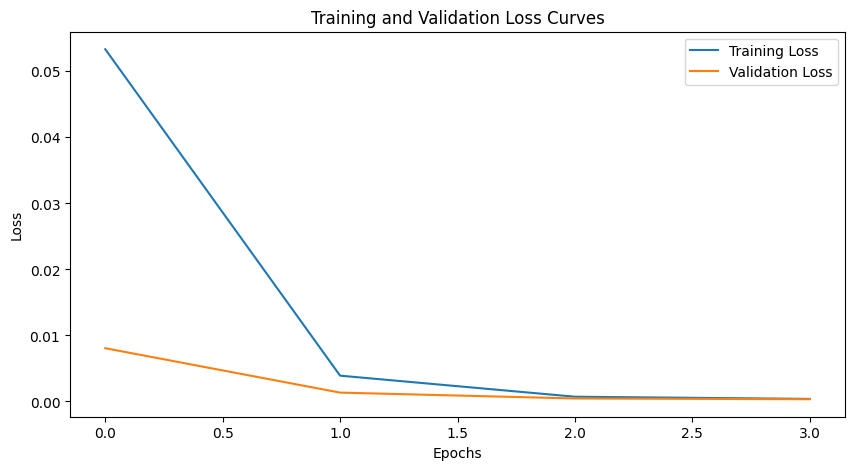

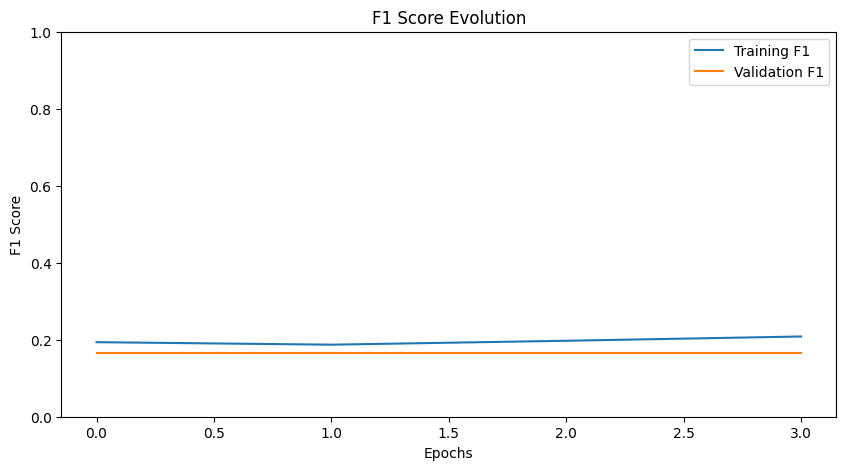


=== Results for ratio=0.00, beta=0.00 ===
Test Metrics:
  Loss: 0.00033811
  Accuracy: 33.084694%
  Precision: 0.00000000
  Recall: 0.33084694
  F1 Score: 0.16449630
  ROC-AUC: 0.38279050
  AP: 0.58633284
  Inference Time/Snapshot: 0.00491952s
  Inference Time/Flow: 0.00000961s
✅ Saved checkpoint (ratio=0.00, beta=0.00)

=== Running ratio=0.00, beta=0.10 ===

Epoch 01/15:
  Train Loss: nan | Train Acc: 65.32% | Train F1: 0.6101
  Val Loss: 0.0072 | Val Acc: 66.92% | Val F1: 0.5365

Epoch 02/15:
  Train Loss: nan | Train Acc: 72.88% | Train F1: 0.7126
  Val Loss: 0.0013 | Val Acc: 78.07% | Val F1: 0.7758

Epoch 03/15:
  Train Loss: nan | Train Acc: 74.82% | Train F1: 0.7435
  Val Loss: 0.0003 | Val Acc: 77.79% | Val F1: 0.7796

Epoch 04/15:
  Train Loss: nan | Train Acc: 74.51% | Train F1: 0.7450
  Val Loss: 0.0001 | Val Acc: 78.25% | Val F1: 0.7851

Epoch 05/15:
  Train Loss: nan | Train Acc: 74.60% | Train F1: 0.7477
  Val Loss: 0.0001 | Val Acc: 77.11% | Val F1: 0.7738

Epoch 06/15:

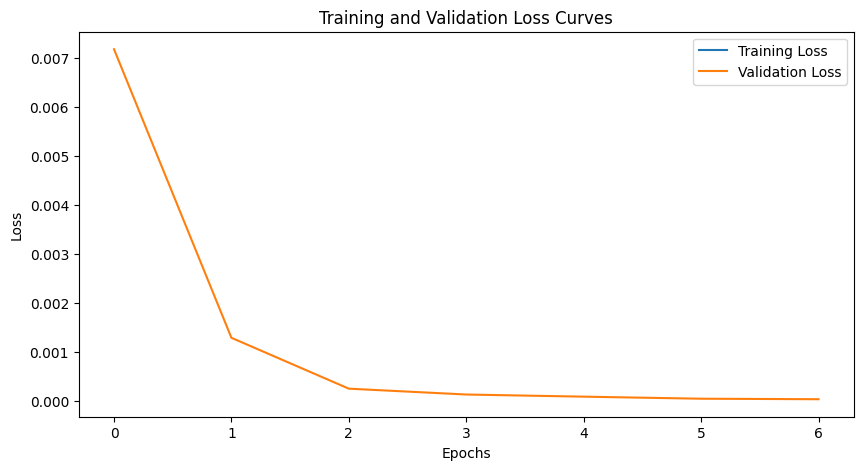

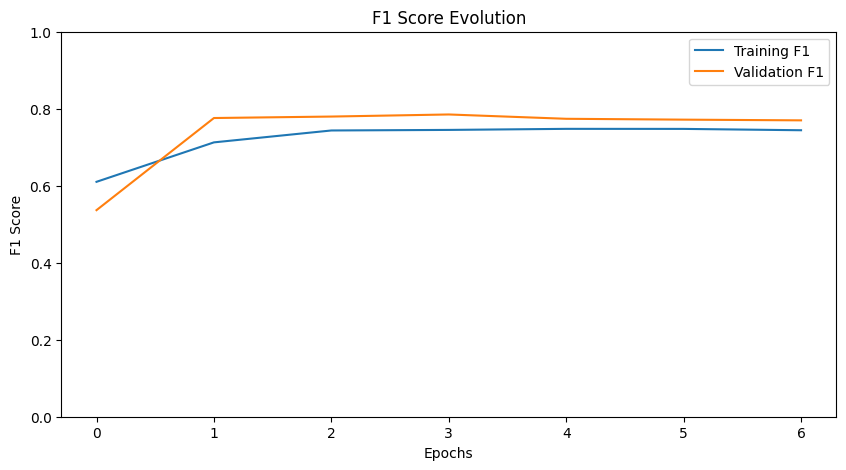


=== Results for ratio=0.00, beta=0.10 ===
Test Metrics:
  Loss: 0.00004400
  Accuracy: 76.822262%
  Precision: 0.84351795
  Recall: 0.76822262
  F1 Score: 0.77076659
  ROC-AUC: 0.86580568
  AP: 0.94345930
  Inference Time/Snapshot: 0.00478860s
  Inference Time/Flow: 0.00000935s
✅ Saved checkpoint (ratio=0.00, beta=0.10)

=== Running ratio=0.00, beta=0.20 ===

Epoch 01/15:
  Train Loss: nan | Train Acc: 43.65% | Train F1: 0.4530
  Val Loss: 0.0074 | Val Acc: 15.38% | Val F1: 0.1754

Epoch 02/15:
  Train Loss: nan | Train Acc: 42.94% | Train F1: 0.4462
  Val Loss: 0.0014 | Val Acc: 42.57% | Val F1: 0.4383

Epoch 03/15:
  Train Loss: nan | Train Acc: 47.97% | Train F1: 0.4937
  Val Loss: 0.0003 | Val Acc: 59.48% | Val F1: 0.5887

Epoch 04/15:
  Train Loss: nan | Train Acc: 49.03% | Train F1: 0.5042
  Val Loss: 0.0001 | Val Acc: 45.25% | Val F1: 0.4619

Epoch 05/15:
  Train Loss: nan | Train Acc: 50.18% | Train F1: 0.5130
  Val Loss: 0.0001 | Val Acc: 57.62% | Val F1: 0.5607

Epoch 06/15:

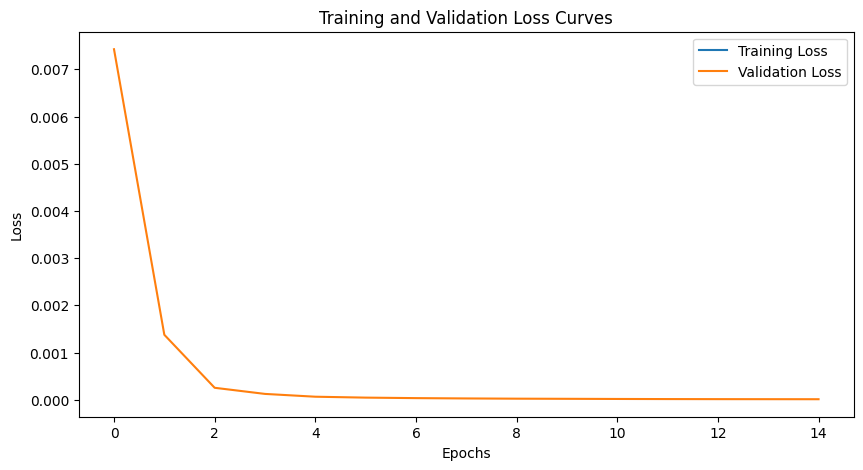

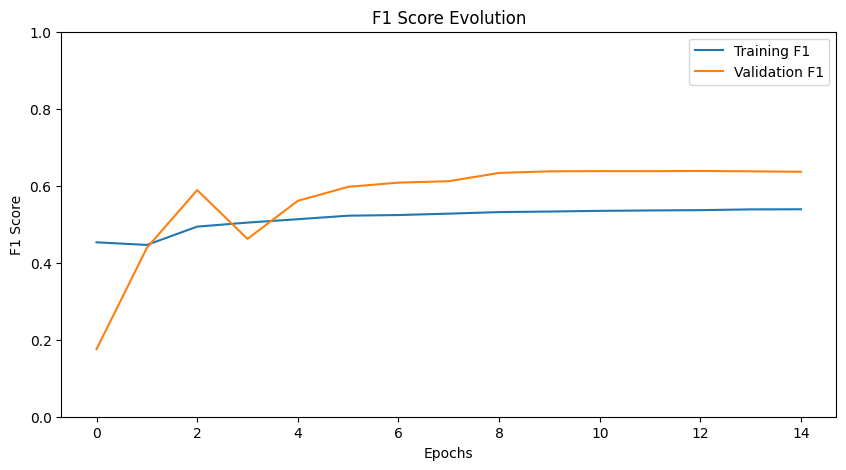


=== Results for ratio=0.00, beta=0.20 ===
Test Metrics:
  Loss: 0.00000998
  Accuracy: 67.164884%
  Precision: 0.70475086
  Recall: 0.67164884
  F1 Score: 0.63578431
  ROC-AUC: 0.42542217
  AP: 0.57890939
  Inference Time/Snapshot: 0.00534575s
  Inference Time/Flow: 0.00001044s
✅ Saved checkpoint (ratio=0.00, beta=0.20)

=== Running ratio=0.00, beta=0.30 ===

Epoch 01/15:
  Train Loss: nan | Train Acc: 44.20% | Train F1: 0.4492
  Val Loss: 0.0056 | Val Acc: 21.81% | Val F1: 0.2255

Epoch 02/15:
  Train Loss: nan | Train Acc: 44.88% | Train F1: 0.4647
  Val Loss: 0.0009 | Val Acc: 24.50% | Val F1: 0.2649

Epoch 03/15:
  Train Loss: nan | Train Acc: 42.82% | Train F1: 0.4450
  Val Loss: 0.0002 | Val Acc: 27.85% | Val F1: 0.2965

Epoch 04/15:
  Train Loss: nan | Train Acc: 45.97% | Train F1: 0.4733
  Val Loss: 0.0001 | Val Acc: 43.00% | Val F1: 0.4353

Epoch 05/15:
  Train Loss: nan | Train Acc: 50.29% | Train F1: 0.5078
  Val Loss: 0.0000 | Val Acc: 59.43% | Val F1: 0.5467

Epoch 06/15:

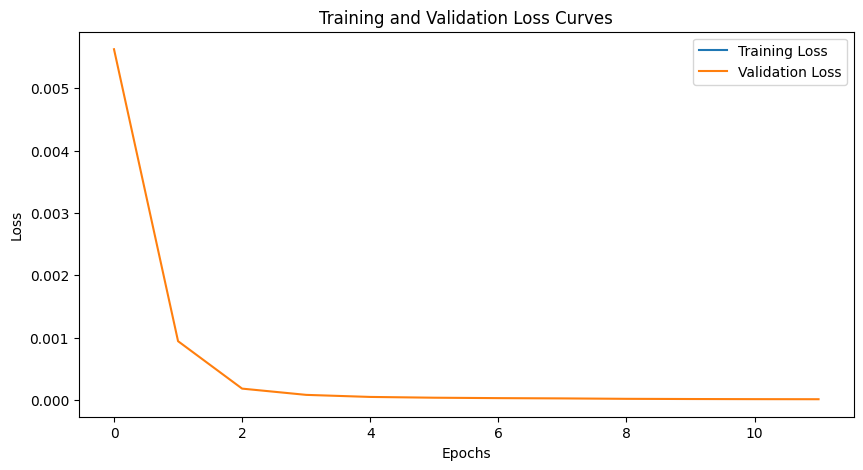

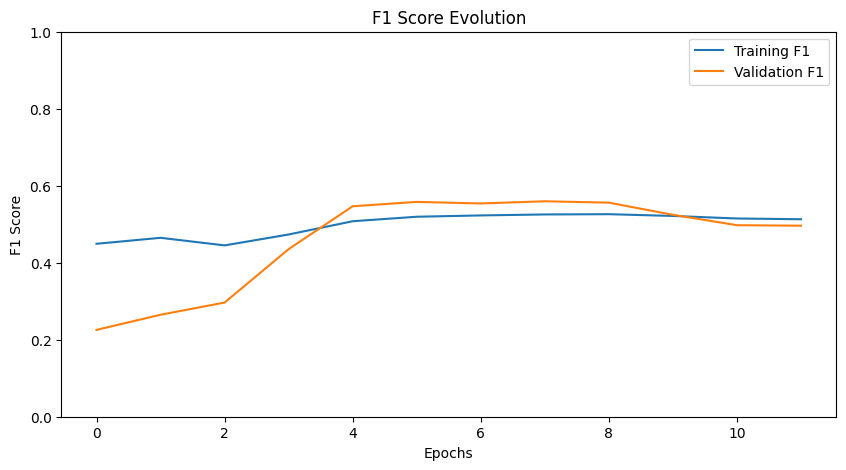


=== Results for ratio=0.00, beta=0.30 ===
Test Metrics:
  Loss: 0.00001138
  Accuracy: 54.946675%
  Precision: 0.63002826
  Recall: 0.54946675
  F1 Score: 0.49623811
  ROC-AUC: 0.28340206
  AP: 0.54766213
  Inference Time/Snapshot: 0.00546731s
  Inference Time/Flow: 0.00001068s
✅ Saved checkpoint (ratio=0.00, beta=0.30)

=== Running ratio=0.00, beta=0.40 ===

Epoch 01/15:
  Train Loss: nan | Train Acc: 62.94% | Train F1: 0.5979
  Val Loss: 0.0050 | Val Acc: 66.93% | Val F1: 0.5372

Epoch 02/15:
  Train Loss: nan | Train Acc: 58.19% | Train F1: 0.5717
  Val Loss: 0.0010 | Val Acc: 65.97% | Val F1: 0.5553


KeyboardInterrupt: 

In [ ]:
# %% AUTO GRID: label_ratio × beta — Full Retrain + Test-Only Evaluation with Checkpoint
import os, gc, time, random
import torch, pandas as pd, numpy as np
from datetime import datetime
from lion_pytorch import Lion

# ---------- Fixed settings ----------
FIXED_LR = 1e-5
FIXED_WD = 1e-5
FIXED_EPOCHS = 15
FIXED_PATIENCE = 3
FIXED_SEED = 42
FIXED_INPUT_DIM = 39
FIXED_HIDDEN_DIM = 128
FIXED_LATENT_DIM = 128
CHECKPOINT_PATH = "full_pipeline_checkpoint.csv"
FINAL_PATH = "full_pipeline_results.csv"

# ---------- Sweep space ----------
LABEL_RATIOS = [i / 10 for i in range(0, 11)]
BETAS = [round(i / 10, 1) for i in range(0, 11) if round(i / 10, 1) != 0.7]

# ---------- Repro ----------
torch.manual_seed(FIXED_SEED)
np.random.seed(FIXED_SEED)
random.seed(FIXED_SEED)

# ---------- Resume if available ----------
def _pair(r, b): return (round(float(r), 3), round(float(b), 3))
if os.path.exists(CHECKPOINT_PATH):
    df_results = pd.read_csv(CHECKPOINT_PATH)
    done_pairs = set(_pair(r, b) for r, b in zip(df_results["label_ratio"], df_results["beta"]))
    print(f"Loaded checkpoint: {len(df_results)} runs already done.")
else:
    df_results = pd.DataFrame(columns=[
        "label_ratio","beta","loss","accuracy","precision",
        "recall","f1","roc_auc","ap",
        "inference_time_snapshot","inference_time_flow","finished_at"
    ])
    done_pairs = set()

# ---------- Helper: label masking ----------
def set_label_masks(snapshots, ratio, seed=42):
    """
    Deterministic label masking:
    - same seed every run
    - same ratio => same masks
    - stable across grid search and manual runs
    """
    gen = torch.Generator(device=device.type).manual_seed(seed)

    for d in snapshots:
        n = int(d.y.numel())
        k = int(n * ratio)

        # trivial cases
        if k <= 0:
            d.label_mask = torch.zeros(n, dtype=torch.bool, device=d.y.device)
            continue

        if k >= n:
            d.label_mask = torch.ones(n, dtype=torch.bool, device=d.y.device)
            continue

        # deterministic selection
        perm = torch.randperm(n, generator=gen, device=d.y.device)
        idx = perm[:k]

        mask = torch.zeros(n, dtype=torch.bool, device=d.y.device)
        mask[idx] = True
        d.label_mask = mask


# ---------- Helper: reporting ----------
def print_report(metrics, title="Test"):
    avg_loss, acc, prec, recall, f1, roc_auc, ap, t_snap, t_flow, *_ = metrics
    print(f"{title} Metrics:")
    print(f"  Loss: {avg_loss:.8f}")
    print(f"  Accuracy: {acc * 100:.6f}%")
    print(f"  Precision: {prec:.8f}")
    print(f"  Recall: {recall:.8f}")
    print(f"  F1 Score: {f1:.8f}")
    print(f"  ROC-AUC: {roc_auc:.8f}")
    print(f"  AP: {ap:.8f}")
    print(f"  Inference Time/Snapshot: {t_snap:.8f}s")
    print(f"  Inference Time/Flow: {t_flow:.8f}s")

# ---------- Core: build, train, eval ----------
def run_full_pipeline(label_ratio, beta):
    print(f"\n=== Running ratio={label_ratio:.2f}, beta={beta:.2f} ===")

    # 1️⃣ reload clean snapshots each run to refresh masking
    train_snaps = torch.load(path+'/train_snapshots.pt')
    val_snaps = torch.load(path+'/validation_snapshots.pt')
    test_snaps = torch.load(path+'/test_snapshots.pt')
    train_snaps = [x.to(device) for x in train_snaps]
    val_snaps = [x.to(device) for x in val_snaps]
    test_snaps = [x.to(device) for x in test_snaps]
    random.shuffle(train_snaps)

    # 2️⃣ apply label masking
    set_label_masks(train_snaps, label_ratio, seed=FIXED_SEED)

    # 3️⃣ build model + optimizer
    model = SemiSupervisedStructTempAE(
        input_dim=FIXED_INPUT_DIM,
        hidden_dim=FIXED_HIDDEN_DIM,
        latent_dim=FIXED_LATENT_DIM
    ).to(device)
    model.beta = beta
    optimizer = Lion(model.parameters(), lr=FIXED_LR, weight_decay=FIXED_WD)

    # 4️⃣ train
    train_model(
        model=model,
        train_snapshots=train_snaps,
        val_snapshots=val_snaps,
        optimizer=optimizer,
        num_epochs=FIXED_EPOCHS,
        patience=FIXED_PATIENCE
    )

    # 5️⃣ evaluate only on test set
    test_metrics = evaluate_model(model, test_snaps)
    print(f"\n=== Results for ratio={label_ratio:.2f}, beta={beta:.2f} ===")
    print_report(test_metrics, "Test")

    # 6️⃣ log + cleanup
    df_results.loc[len(df_results)] = [
        label_ratio, beta,
        test_metrics[0], test_metrics[1], test_metrics[2],
        test_metrics[3], test_metrics[4], test_metrics[5],
        test_metrics[6], test_metrics[7], test_metrics[8],
        datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ]
    df_results.to_csv(CHECKPOINT_PATH, index=False)
    print(f"✅ Saved checkpoint (ratio={label_ratio:.2f}, beta={beta:.2f})")
    del model, optimizer; torch.cuda.empty_cache(); gc.collect()

# ---------- Run sweep ----------
total = len(LABEL_RATIOS) * len(BETAS)
done = len(done_pairs)
print(f"Total combos: {total}, done: {done}, remaining: {total - done}")
for ratio in LABEL_RATIOS:
    for beta in BETAS:
        if _pair(ratio, beta) in done_pairs:
            print(f"Skip ratio={ratio:.1f}, beta={beta:.1f} (already done)")
            continue
        try:
            run_full_pipeline(ratio, beta)
        except Exception as e:
            print(f"⚠️ Error at ratio={ratio:.2f}, beta={beta:.2f}: {e}")
            continue

print("\n✅ All runs finished.")
df_results.to_csv(FINAL_PATH, index=False)
print(f"Saved final results to {FINAL_PATH}")
